## **Imports**


In [32]:
import openpyxl
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('rslp')
from nltk.stem import RSLPStemmer

# Configurar stopwords e stemmer
stop_words = stopwords.words('portuguese')
stemmer = RSLPStemmer()

import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vendr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vendr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vendr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vendr\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## **Verificação de Balanceamento do DataSET de Treino**

In [33]:
CaminhoTreino = "../data/BKP_ComentariosTI_TreinoV3.csv"

df = pd.read_csv(CaminhoTreino, delimiter=";")


# Carregar os dados de Treino
CaminhoPLan1 = CaminhoTreino
df = pd.read_csv(CaminhoTreino, delimiter=";")
df = df[df['sentiment'] != 'Neutro']
df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])


#Caminmhoplanilha Real

CaminhoPLan2 = "../data/PESQUISA_TIC.xlsx"
dfQuest = pd.read_excel(CaminhoPLan2)
dfQuest = dfQuest[["Comentario","Analise"]].dropna()
dfQuest = dfQuest[dfQuest['Analise'] != 'Neutro']
dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"],[0, 1])
####################################################################################################


C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\2689036768.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])
C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\2689036768.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"],[0, 1])


In [7]:
# Separacao dos dados por sentimento
df.groupby('sentiment').count()

,Comentario
sentiment,
Negativo,1205
Neutro,1205
Positivo,1205


In [8]:
df = df[df['sentiment'] != 'Neutro']
# Separacao dos dados por sentimento
df.groupby('sentiment').count()

,Comentario
sentiment,
Negativo,1205
Positivo,1205


## **Versão Inicial**

In [35]:
import pickle

# Função para pré-processar texto
def preprocess_text(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_words = [stemmer.stem(word) for word in filtered_sentence]
    return ' '.join(stemmed_words)


# Aplicar pré-processamento
df['Comentario'] = df['Comentario'].apply(preprocess_text)

# Aplicar pré-processamento COmentários reais
dfQuest['Comentario'] = dfQuest['Comentario'].apply(preprocess_text)




# Vetorização
cv = CountVectorizer(lowercase=True, stop_words=None, ngram_range=(1, 2), tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize)
text_counts = cv.fit_transform(df['Comentario'])

text_counts2 = cv.transform(dfQuest['Comentario'])



# Dividir o dataset
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['classification'], test_size=0.34, random_state=1, shuffle=True)

# Definir modelos para comparação
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC()
}


# Dicionário para armazenar os resultados
results = {}
best_model = None
best_accuracy = 0

# Treinar e avaliar os modelos
for name, model in models.items():
    print(f"Treinando e avaliando o modelo {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
    class_report = metrics.classification_report(y_test, y_pred, labels=[1, 0])

    results[name] = {
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    }

    # Previsão para os dados reais
    y_pred2 = model.predict(text_counts2)

    accuracy_real = metrics.accuracy_score(dfQuest['AnaliseBin'], y_pred2)
    conf_matrix_real = metrics.confusion_matrix(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])
    class_report_real = metrics.classification_report(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])

    results[name].update({
        'accuracy_real': accuracy_real,
        'conf_matrix_real': conf_matrix_real,
        'class_report_real': class_report_real
    })

    # Verificar se é o melhor modelo com base na acurácia dos dados reais
    if accuracy_real > best_accuracy:
        best_accuracy = accuracy_real
        best_model = model
        best_model_name = name

# Exibir o melhor modelo
print(f"Melhor modelo: {best_model_name} com acurácia real de {best_accuracy:.2f}")

# Salvar o melhor modelo em um arquivo pickle
if best_model is not None:
    with open('../model/best_sentiment_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Modelo {best_model_name} salvo como 'best_sentiment_model.pkl'.")

    # Salvar o vetorizador em um arquivo pickle
    with open('../model/vectorizer.pkl', 'wb') as f:
        pickle.dump(cv, f)
    print("Vetorizador salvo como './model/vectorizer.pkl'.")
else:
    print("Nenhum modelo foi salvo.")

Treinando e avaliando o modelo MultinomialNB...
Treinando e avaliando o modelo LogisticRegression...
Treinando e avaliando o modelo LinearSVC...
Melhor modelo: MultinomialNB com acurácia real de 0.81
Modelo MultinomialNB salvo como 'best_sentiment_model.pkl'.
Vetorizador salvo como './model/vectorizer.pkl'.


c:\Users\vendr\Documents\GitHub\AnaliseSentimento\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### **Resultados**

In [29]:
# Mostrar resultados
for name, result in results.items():
    print(f"\nResultados para {name}:")
    print(f"Acurácia (Treinamento): {result['accuracy']:.2f}")
    print("Relatório de Classificação (Treinamento):")
    print(result['class_report'])

    print(f"Acurácia (Dados Reais): {result['accuracy_real']:.2f}")
    print("Relatório de Classificação (Dados Reais):")
    print(result['class_report_real'])


Resultados para MultinomialNB:
Acurácia (Treinamento): 0.97
Relatório de Classificação (Treinamento):
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       425
           0       0.98      0.96      0.97       395

    accuracy                           0.97       820
   macro avg       0.97      0.97      0.97       820
weighted avg       0.97      0.97      0.97       820

Acurácia (Dados Reais): 0.76
Relatório de Classificação (Dados Reais):
              precision    recall  f1-score   support

           1       0.67      0.89      0.76        18
           0       0.89      0.67      0.76        24

    accuracy                           0.76        42
   macro avg       0.78      0.78      0.76        42
weighted avg       0.79      0.76      0.76        42


Resultados para LogisticRegression:
Acurácia (Treinamento): 0.98
Relatório de Classificação (Treinamento):
              precision    recall  f1-score   support

         

#### **Gráficos**

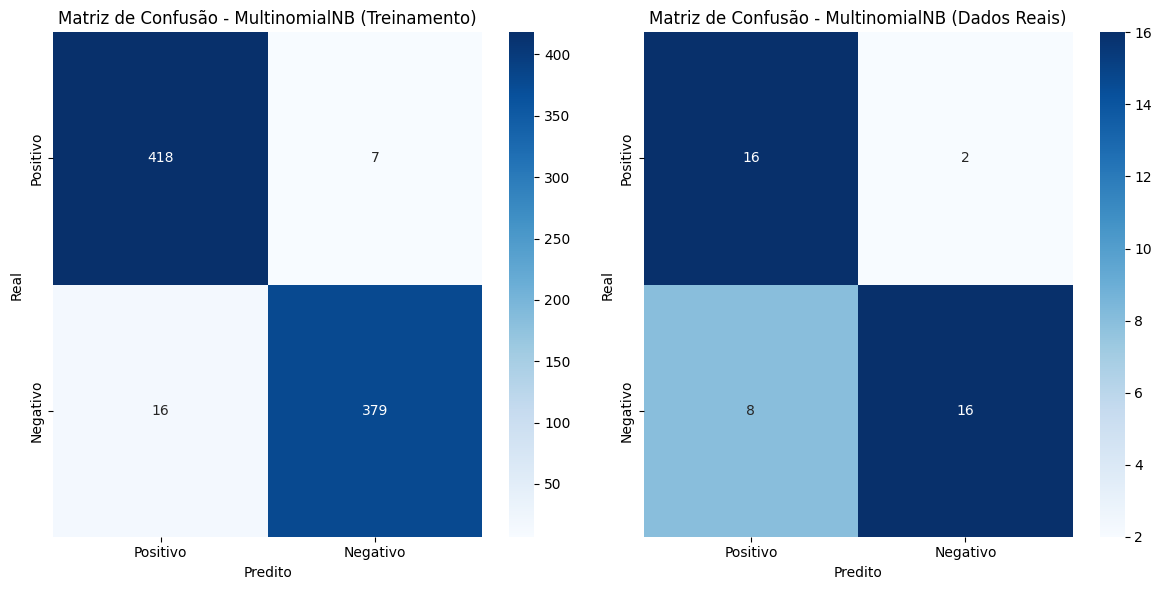

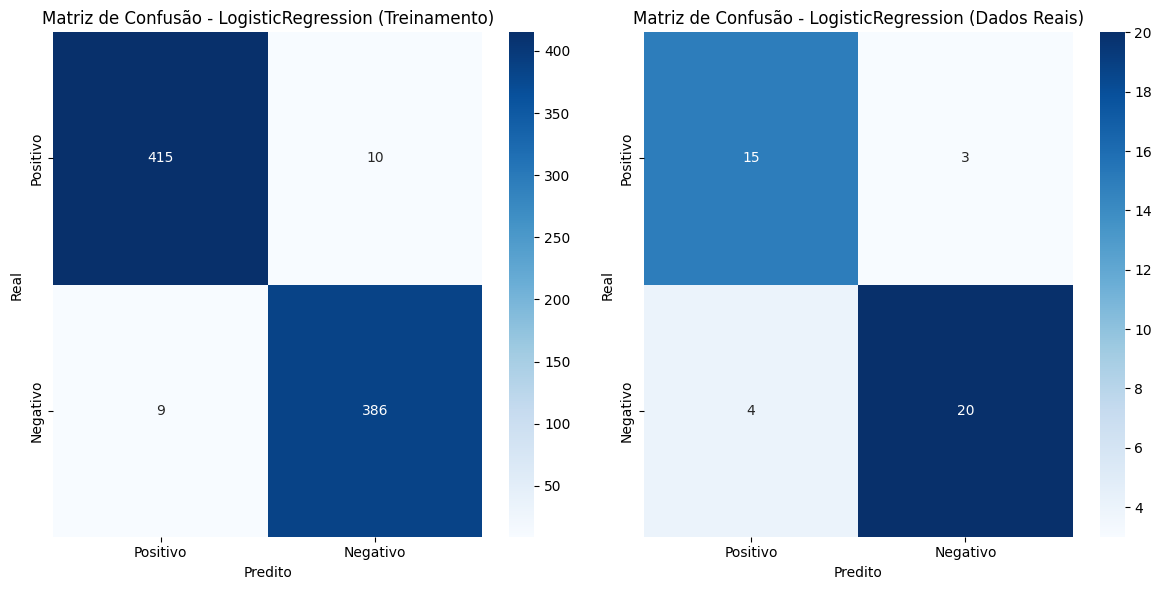

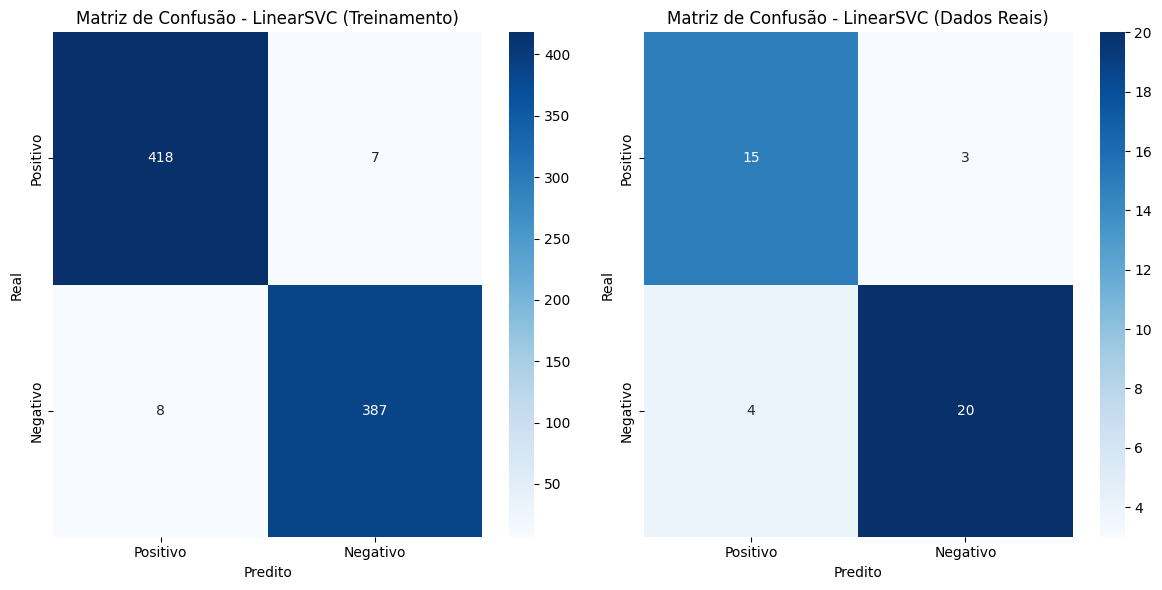

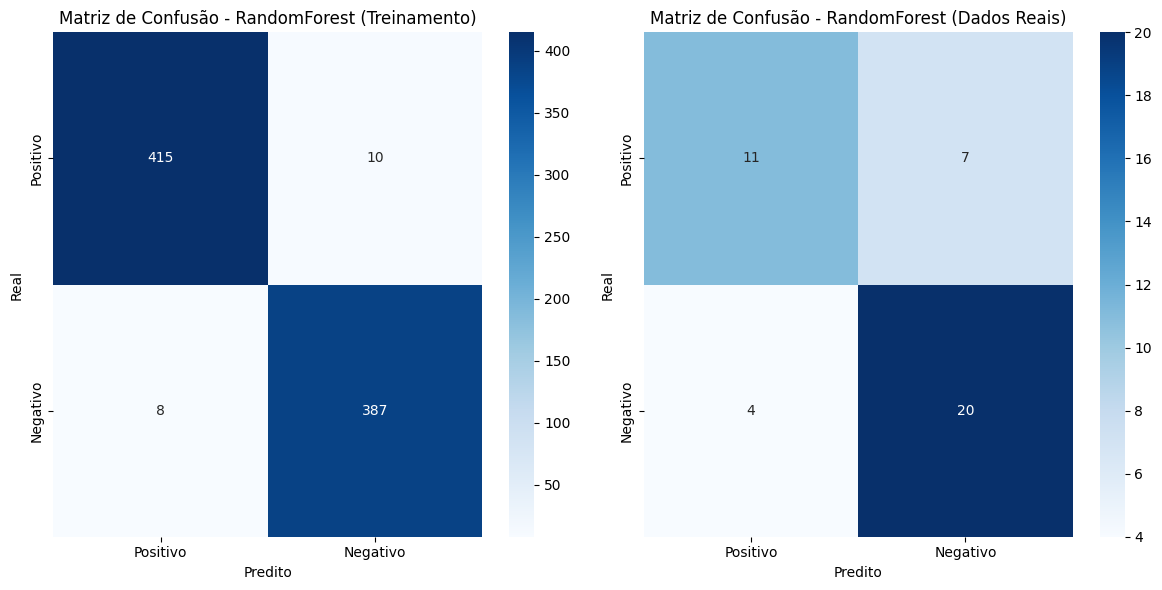

In [30]:
# Configurações gerais do gráfico
plt.rcParams['figure.figsize'] = (8, 4)  # Ajuste o tamanho conforme necessário

# Mostrar resultados Gráficos
for name, result in results.items():
    # Criar uma figura com dois subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plotar a matriz de confusão para Treinamento
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positivo', 'Negativo'],
                yticklabels=['Positivo', 'Negativo'],
                ax=axes[0])
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')
    axes[0].set_title(f'Matriz de Confusão - {name} (Treinamento)')

    # Plotar a matriz de confusão para Dados Reais
    sns.heatmap(result['conf_matrix_real'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positivo', 'Negativo'],
                yticklabels=['Positivo', 'Negativo'],
                ax=axes[1])
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')
    axes[1].set_title(f'Matriz de Confusão - {name} (Dados Reais)')

    # Ajustar layout
    plt.tight_layout()
    plt.show()

## **Versão com Ajuste De stemização**

In [22]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn import metrics
import pandas as pd

# Função para pré-processar texto (Sem stemização)
def preprocess_text_no_stem(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

# Configurar stopwords
stop_words = stopwords.words('portuguese')

# Carregar os dados
df = df[df['sentiment'] != 'Neutro']
df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])


dfQuest = pd.read_excel(CaminhoPLan2)
dfQuest = dfQuest[dfQuest['Analise'] != 'Neutro']
dfQuest = dfQuest[["Comentario","Analise"]].dropna()
dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"], [0, 1])

# Aplicar pré-processamento
df['Comentario'] = df['Comentario'].apply(preprocess_text_no_stem)
dfQuest['Comentario'] = dfQuest['Comentario'].apply(preprocess_text_no_stem)

# Vetorização
cv = CountVectorizer(lowercase=True, stop_words=None, ngram_range=(1, 2), tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize)
text_counts = cv.fit_transform(df['Comentario'])
text_counts2 = cv.transform(dfQuest['Comentario'])

# Dividir o dataset
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['classification'], test_size=0.34, random_state=1, shuffle=True)

# Modelos para comparação
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(),
    'RandomForest': RandomForestClassifier()
    #'XGBoost': XGBClassifier(eval_metric='mlogloss')
}

# Validação cruzada com KFold = 5
kf = KFold(n_splits=5, shuffle=True, random_state=1)
results = {}

for name, model in models.items():
    print(f"Treinando e avaliando o modelo {name}...")
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
    class_report = metrics.classification_report(y_test, y_pred, labels=[1, 0])

    # Previsão para os dados reais
    y_pred2 = model.predict(text_counts2)
    accuracy_real = metrics.accuracy_score(dfQuest['AnaliseBin'], y_pred2)
    conf_matrix_real = metrics.confusion_matrix(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])
    class_report_real = metrics.classification_report(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])

    results[name] = {
        'cross_val_mean': cv_results.mean(),
        'cross_val_std': cv_results.std(),
        'accuracy_test': accuracy,
        'conf_matrix_test': conf_matrix,
        'class_report_test': class_report,
        'accuracy_real': accuracy_real,
        'conf_matrix_real': conf_matrix_real,
        'class_report_real': class_report_real
    }

# Exibir os resultados
for model_name, result in results.items():
    print(f"\nModelo: {model_name}")
    print(f"Cross Validation Accuracy: {result['cross_val_mean']} (± {result['cross_val_std']})")
    print(f"Acurácia no Teste: {result['accuracy_test']}")
    print(f"Confusion Matrix (Teste):\n{result['conf_matrix_test']}")
    print(f"Classification Report (Teste):\n{result['class_report_test']}")
    print(f"Acurácia nos Dados Reais: {result['accuracy_real']}")
    print(f"Confusion Matrix (Dados Reais):\n{result['conf_matrix_real']}")
    print(f"Classification Report (Dados Reais):\n{result['class_report_real']}")

C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\1409260283.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])
C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\1409260283.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"], [0, 1])
c:\Users\vendr\Documents\GitHub\AnaliseSentimento\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_patt

Treinando e avaliando o modelo MultinomialNB...
Treinando e avaliando o modelo LogisticRegression...
Treinando e avaliando o modelo LinearSVC...
Treinando e avaliando o modelo RandomForest...

Modelo: MultinomialNB
Cross Validation Accuracy: 0.9773584905660379 (± 0.007280400567792593)
Acurácia no Teste: 0.973170731707317
Confusion Matrix (Teste):
[[418   7]
 [ 15 380]]
Classification Report (Teste):
              precision    recall  f1-score   support

           1       0.97      0.98      0.97       425
           0       0.98      0.96      0.97       395

    accuracy                           0.97       820
   macro avg       0.97      0.97      0.97       820
weighted avg       0.97      0.97      0.97       820

Acurácia nos Dados Reais: 0.6666666666666666
Confusion Matrix (Dados Reais):
[[17  1]
 [13 11]]
Classification Report (Dados Reais):
              precision    recall  f1-score   support

           1       0.57      0.94      0.71        18
           0       0.92     

## **Versão com Ajuste De kfold**

In [24]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn import metrics
import pandas as pd

# Função para pré-processar texto (Com stemização)
def preprocess_text(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

# Configurar stopwords
stop_words = stopwords.words('portuguese')

# Carregar os dados
df = df[df['sentiment'] != 'Neutro']
df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])


dfQuest = pd.read_excel(CaminhoPLan2)
dfQuest = dfQuest[dfQuest['Analise'] != 'Neutro']
dfQuest = dfQuest[["Comentario","Analise"]].dropna()
dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"], [0, 1])

# Aplicar pré-processamento
df['Comentario'] = df['Comentario'].apply(preprocess_text)
dfQuest['Comentario'] = dfQuest['Comentario'].apply(preprocess_text)

# Vetorização usando TfidfVectorizer
tfidf = TfidfVectorizer(lowercase=True, stop_words=None, ngram_range=(1, 2), tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize)
text_counts = tfidf.fit_transform(df['Comentario'])
text_counts2 = tfidf.transform(dfQuest['Comentario'])

# Dividir o dataset
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['classification'], test_size=0.34, random_state=1, shuffle=True)

# Modelos para comparação
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(),
    'RandomForest': RandomForestClassifier()
    #'XGBoost': XGBClassifier(eval_metric='mlogloss')
}

# Validação cruzada com KFold = 5
kf = KFold(n_splits=5, shuffle=True, random_state=1)
results = {}

for name, model in models.items():
    print(f"Treinando e avaliando o modelo {name}...")
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[ 1, 0])
    class_report = metrics.classification_report(y_test, y_pred, labels=[ 1, 0])

    # Previsão para os dados reais
    y_pred2 = model.predict(text_counts2)
    accuracy_real = metrics.accuracy_score(dfQuest['AnaliseBin'], y_pred2)
    conf_matrix_real = metrics.confusion_matrix(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])
    class_report_real = metrics.classification_report(dfQuest['AnaliseBin'], y_pred2, labels=[ 1, 0])

    results[name] = {
        'cross_val_mean': cv_results.mean(),
        'cross_val_std': cv_results.std(),
        'accuracy_test': accuracy,
        'conf_matrix_test': conf_matrix,
        'class_report_test': class_report,
        'accuracy_real': accuracy_real,
        'conf_matrix_real': conf_matrix_real,
        'class_report_real': class_report_real
    }

# Exibir os resultados
for model_name, result in results.items():
    print(f"\nModelo: {model_name}")
    print(f"Cross Validation Accuracy: {result['cross_val_mean']} (± {result['cross_val_std']})")
    print(f"Acurácia no Teste: {result['accuracy_test']}")
    print(f"Confusion Matrix (Teste):\n{result['conf_matrix_test']}")
    print(f"Classification Report (Teste):\n{result['class_report_test']}")
    print(f"Acurácia nos Dados Reais: {result['accuracy_real']}")
    print(f"Confusion Matrix (Dados Reais):\n{result['conf_matrix_real']}")
    print(f"Classification Report (Dados Reais):\n{result['class_report_real']}")

C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\2918982566.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])
C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\2918982566.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"], [0, 1])
c:\Users\vendr\Documents\GitHub\AnaliseSentimento\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_patt

Treinando e avaliando o modelo MultinomialNB...
Treinando e avaliando o modelo LogisticRegression...
Treinando e avaliando o modelo LinearSVC...
Treinando e avaliando o modelo RandomForest...

Modelo: MultinomialNB
Cross Validation Accuracy: 0.9773584905660379 (± 0.007804826192447078)
Acurácia no Teste: 0.973170731707317
Confusion Matrix (Teste):
[[418   7]
 [ 15 380]]
Classification Report (Teste):
              precision    recall  f1-score   support

           1       0.97      0.98      0.97       425
           0       0.98      0.96      0.97       395

    accuracy                           0.97       820
   macro avg       0.97      0.97      0.97       820
weighted avg       0.97      0.97      0.97       820

Acurácia nos Dados Reais: 0.7142857142857143
Confusion Matrix (Dados Reais):
[[17  1]
 [11 13]]
Classification Report (Dados Reais):
              precision    recall  f1-score   support

           1       0.61      0.94      0.74        18
           0       0.93     

## **Ajuste com Sistema de Votação de Modelos**

C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\3572305574.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])
C:\Users\vendr\AppData\Local\Temp\ipykernel_16596\3572305574.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"], [0, 1])
c:\Users\vendr\Documents\GitHub\AnaliseSentimento\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_patt

Treinando e avaliando o modelo MultinomialNB...
Treinando e avaliando o modelo LogisticRegression...
Treinando e avaliando o modelo LinearSVC...
Treinando e avaliando o modelo RandomForest...
Resultados do sistema de votação:
Acurácia (Sistema de Votação): 0.83
Matriz de Confusão (Sistema de Votação):
[[15  3]
 [ 4 20]]
Relatório de Classificação (Sistema de Votação):
              precision    recall  f1-score   support

           1       0.79      0.83      0.81        18
           0       0.87      0.83      0.85        24

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.84      0.83      0.83        42



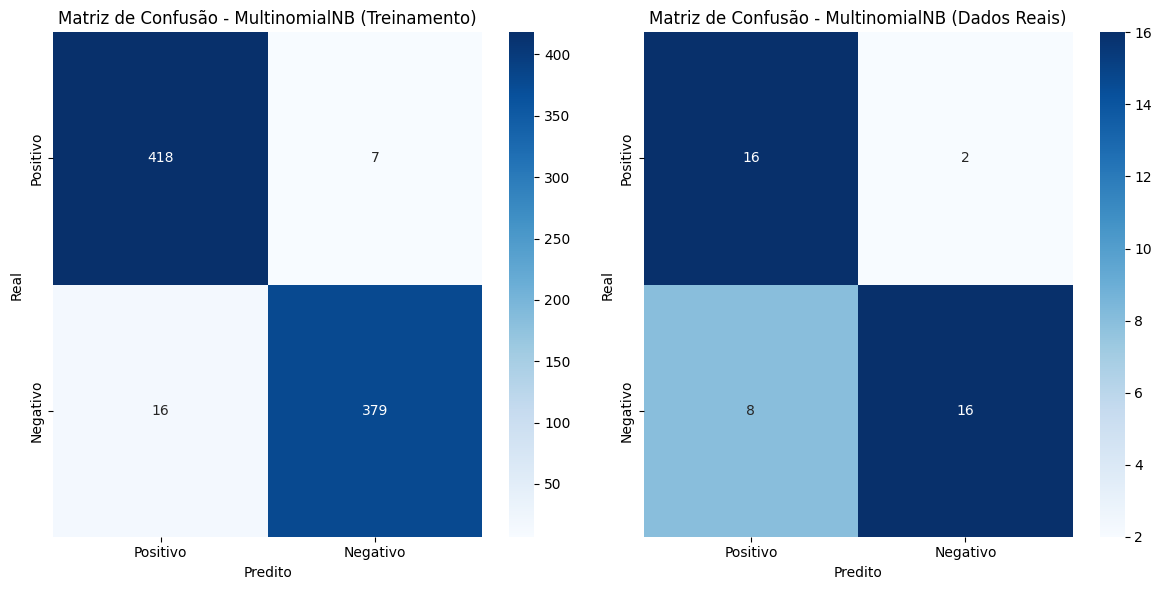

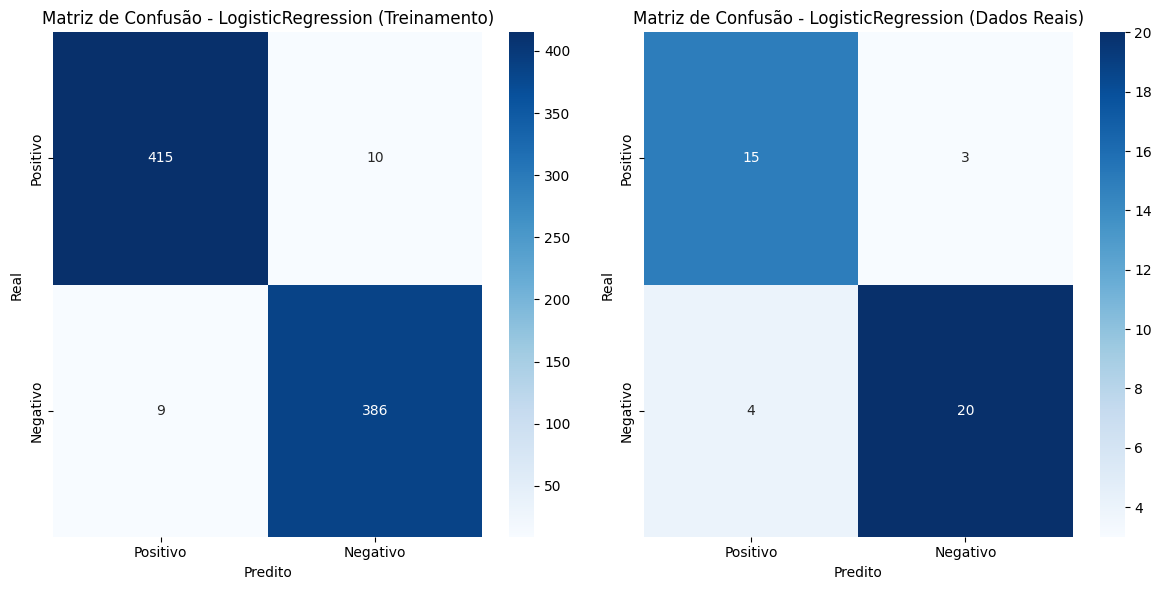

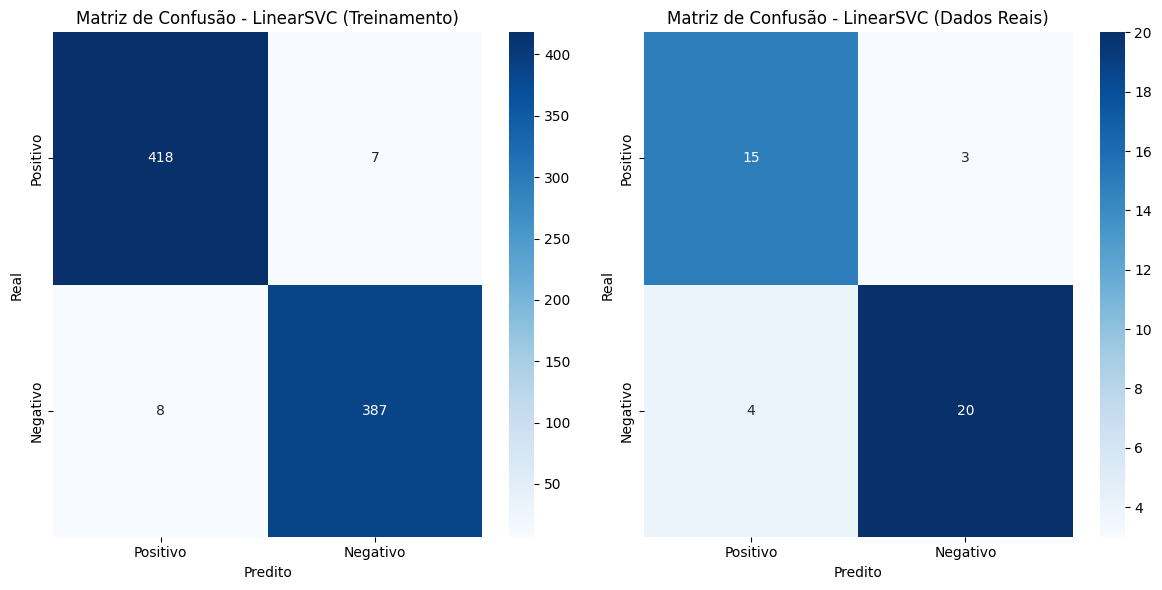

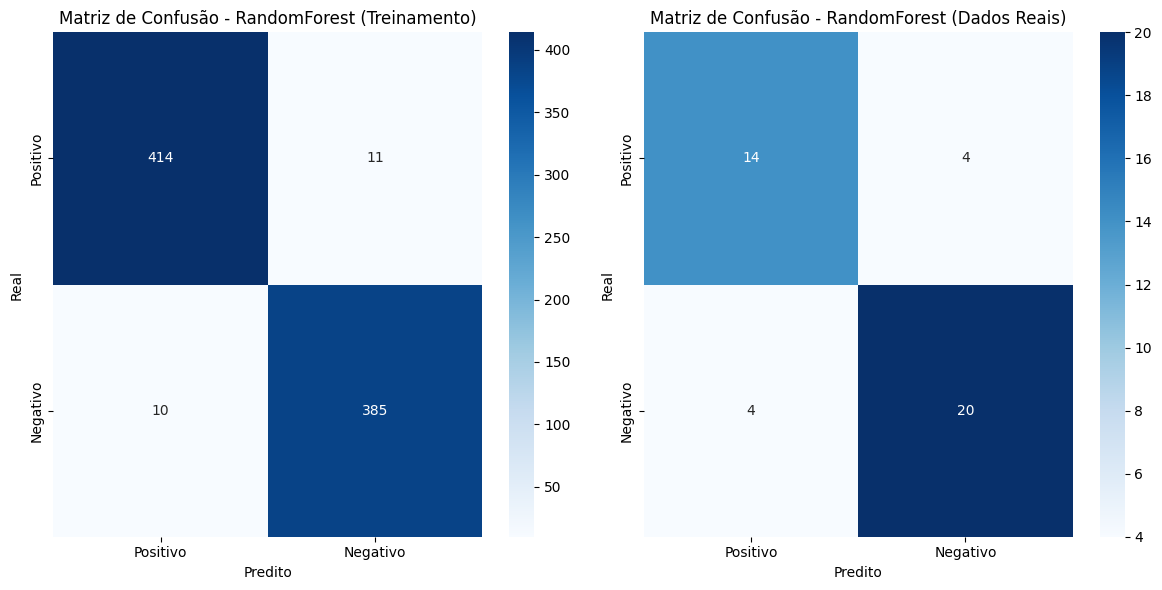

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Função para pré-processar texto
def preprocess_text(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_words = [stemmer.stem(word) for word in filtered_sentence]
    return ' '.join(stemmed_words)

# Configurar stopwords e stemmer
stop_words = stopwords.words('portuguese')
stemmer = RSLPStemmer()


# Carregar os dados
df = df[df['sentiment'] != 'Neutro']
df['classification'] = df["sentiment"].replace(["Negativo", "Positivo"], [0, 1])

# Carregar dados reais
dfQuest = pd.read_excel(CaminhoPLan2)
dfQuest = dfQuest[["Comentario", "Analise"]].dropna()
dfQuest = dfQuest[dfQuest['Analise'] != 'Neutro']
dfQuest['AnaliseBin'] = dfQuest["Analise"].replace(["Neg", "Pos"], [0, 1])

# Aplicar pré-processamento
df['Comentario'] = df['Comentario'].apply(preprocess_text)
dfQuest['Comentario'] = dfQuest['Comentario'].apply(preprocess_text)

# Vetorização
cv = CountVectorizer(lowercase=True, stop_words=None, ngram_range=(1, 2), tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize)
text_counts = cv.fit_transform(df['Comentario'])
text_counts2 = cv.transform(dfQuest['Comentario'])

# Dividir o dataset
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['classification'], test_size=0.34, random_state=1, shuffle=True)

# Definir modelos para comparação
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(),
    'RandomForest': RandomForestClassifier()
    
}

# Dicionário para armazenar os resultados
results = {}

# Criar uma matriz de previsões para o sistema de votação
voting_predictions = np.zeros((text_counts2.shape[0], len(models)))

# Treinar e avaliar os modelos
for i, (name, model) in enumerate(models.items()):
    print(f"Treinando e avaliando o modelo {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])
    class_report = metrics.classification_report(y_test, y_pred, labels=[1, 0])

    results[name] = {
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    }

    # Previsão para os dados reais
    y_pred2 = model.predict(text_counts2)
    voting_predictions[:, i] = y_pred2

    accuracy_real = metrics.accuracy_score(dfQuest['AnaliseBin'], y_pred2)
    conf_matrix_real = metrics.confusion_matrix(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])
    class_report_real = metrics.classification_report(dfQuest['AnaliseBin'], y_pred2, labels=[1, 0])

    results[name].update({
        'accuracy_real': accuracy_real,
        'conf_matrix_real': conf_matrix_real,
        'class_report_real': class_report_real
    })

# Aplicar sistema de votação
voting_predictions_majority = np.round(np.mean(voting_predictions, axis=1)).astype(int)

# Comparar com as informações reais
accuracy_voting = metrics.accuracy_score(dfQuest['AnaliseBin'], voting_predictions_majority)
conf_matrix_voting = metrics.confusion_matrix(dfQuest['AnaliseBin'], voting_predictions_majority, labels=[1, 0])
class_report_voting = metrics.classification_report(dfQuest['AnaliseBin'], voting_predictions_majority, labels=[1, 0])

print("Resultados do sistema de votação:")
print(f"Acurácia (Sistema de Votação): {accuracy_voting:.2f}")
print("Matriz de Confusão (Sistema de Votação):")
print(conf_matrix_voting)
print("Relatório de Classificação (Sistema de Votação):")
print(class_report_voting)

# Mostrar resultados Gráficos
for name, result in results.items():
    # Criar uma figura com dois subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plotar a matriz de confusão para Treinamento
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positivo', 'Negativo'],
                yticklabels=['Positivo', 'Negativo'],
                ax=axes[0])
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')
    axes[0].set_title(f'Matriz de Confusão - {name} (Treinamento)')

    # Plotar a matriz de confusão para Dados Reais
    sns.heatmap(result['conf_matrix_real'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positivo', 'Negativo'],
                yticklabels=['Positivo', 'Negativo'],
                ax=axes[1])
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')
    axes[1].set_title(f'Matriz de Confusão - {name} (Dados Reais)')

    # Ajustar layout
    plt.tight_layout()
    plt.show()